In [36]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time    

In [37]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle
import random

from itertools import chain,product
from scipy import stats as st
from scipy import special as sp 

In [38]:
import optimizer as O

In [39]:
class Trajectory:
    """
    A trajectory consisting of states, corresponding actions, and outcomes.

    Args:
        transitions: The transitions of this trajectory as an array of
            tuples `(state_from, action, state_to)`. Note that `state_to` of
            an entry should always be equal to `state_from` of the next
            entry.
    """
    def __init__(self, transitions):
        self._t = transitions

    def transitions(self):
        """
        The transitions of this trajectory.

        Returns:
            All transitions in this trajectory as array of tuples
            `(state_from, action, state_to)`.
        """
        return self._t

    def states(self):
        """
        The states visited in this trajectory.

        Returns:
            All states visited in this trajectory as iterator in the order
            they are visited. If a state is being visited multiple times,
            the iterator will return the state multiple times according to
            when it is visited.
        """
        return map(lambda x: x[0], chain(self._t, [(self._t[-1][2], 0, 0)]))

    def __repr__(self):
        return "Trajectory({})".format(repr(self._t))

    def __str__(self):
        return "{}".format(self._t)

In [51]:
import numpy as np

class DiscreteRobotarium:
    def __init__(self, nx=50, ny=50, nu=9):
        """
        Initializes the Discrete Robotarium environment.

        Parameters:
        nx (int): Number of discrete steps in the x-dimension.
        ny (int): Number of discrete steps in the y-dimension.
        nu (int): Number of control actions (5: stay, up, down, left, right).
        """
        # Discretization parameters
        self.nx = nx
        self.ny = ny
        self.nu = nu

        # Define the grid boundaries
        self.x_bounds = [-1.5, 1.5]
        self.y_bounds = [-1, 1]

        # Discretized grid points
        self.x = np.linspace(self.x_bounds[0], self.x_bounds[1], self.nx)
        self.y = np.linspace(self.y_bounds[0], self.y_bounds[1], self.ny)

        # Control inputs: [stay, up, down, left, right]
        # self.u = np.array([[0, 0], [0, 0.15], [0, -0.15], [-0.15, 0], [0.15, 0], [0.15,0.15],[0.15,-0.15],[-0.15,0.15],[-0.15,-0.15]])
        self.u = np.array([[0, 0], [0, 1.5], [0, -1.5], [-1.5, 0], [1.5, 0], [1.5,0.5],[1.5,-1.5],[-1.5,1.5],[-1.5,-1.5]])
        # Total number of states
        self.num_states = self.nx * self.ny
        self.time_step = 0.033
        # Transition table (precompute transitions for efficiency)
                
        self.transition_prob = np.zeros([self.num_states, self.nu, self.num_states])
        
        for _ in range(100):
            for i in range(self.num_states):
                for k in range(self.nu):
                    x_next = self.step(self.get_state(i), self.u[k])
                    next_state_index = self.get_index(x_next)
                    self.transition_prob[i,k,next_state_index] += 1.0
        
        for i in range(self.num_states):
            for k in range(self.nu):
                self.transition_prob[i,k] = self.transition_prob[i,k]/np.sum(self.transition_prob[i,k])

    def step(self, state, control):
        """
        Simulates one step of the dynamics.

        Parameters:
        state (array): Current state [x, y].
        control (array): Control input [dx, dy].

        Returns:
        array: Next state [x, y].
        """
        
        
        x_next = state[0] + self.time_step*control[0] + 1.0*np.random.normal(0,0.0001)
        y_next = state[1] + self.time_step*control[1] + 1.0*np.random.normal(0,0.0001)

        # # Clip the next state to remain within bounds
        # x_next = np.clip(x_next, self.x_bounds[0], self.x_bounds[1])
        # y_next = np.clip(y_next, self.y_bounds[0], self.y_bounds[1])

        return np.array([x_next, y_next])

    def get_index(self, state):
        """
        Maps a continuous state to a discrete index.

        Parameters:
        state (array): Continuous state [x, y].

        Returns:
        int: Discrete state index.
        """
        ind_x = np.argmin((state[0] - self.x) ** 2)
        ind_y = np.argmin((state[1] - self.y) ** 2)
        return ind_x + ind_y * self.nx

    def get_state(self, index):
        """
        Maps a discrete index to a continuous state.

        Parameters:
        index (int): Discrete state index.

        Returns:
        array: Continuous state [x, y].
        """
        ind_y, ind_x = divmod(index, self.nx)
        return np.array([self.x[ind_x], self.y[ind_y]])

    def simulate(self, x0, policy, T):
        """
        Simulates a trajectory given an initial state and policy.

        Parameters:
        x0 (array): Initial state [x, y].
        policy (array): Probabilistic policy [num_states x nu].
        T (float): Duration of simulation.

        Returns:
        array, array: Trajectory of states and actions.
        """
        horizon_length = int(T)
        trajectory = []
        x = np.empty([2, horizon_length + 1])
        x[:, 0] = x0
        u = np.empty(horizon_length, dtype=int)

        for i in range(horizon_length):
            current_index = self.get_index(x[:, i])
            u[i] = np.random.choice(self.nu, p=policy[current_index])
            x[:, i + 1] = self.step(x[:, i], self.u[u[i]])
            # if x[0, i + 1] <= np.array([-1.5]) or x[0, i + 1] >= np.array([1.5])  or x[1, i + 1] <= np.array([-1.0]) or x[1, i + 1] >= np.array([1.0]):
            #     print('Touched the boundary wall')
            #     break
            
            trajectory.append((current_index, u[i], self.get_index(x[:, i + 1])))

        return x, u
  
    def generate_trajectories(self, x0, policy,T):
        """
        Generates trajectories based on the given policy, terminating when near the goal.

        Args:
            x0: Initial state (2D array).
            policy: A mapping from state indices to probabilities over actions.
            goal: Goal state as a 2D array or vector.
            margin: Distance margin to consider state x as near the goal.

        Returns:
            A Trajectory object containing the state transitions.
        """
        horizon_length = int(T)
        trajectory = []
        x = np.empty([2, horizon_length + 1])
        x[:, 0] = x0
        u = np.empty(horizon_length, dtype=int)

        for i in range(horizon_length):
            current_index = self.get_index(x[:, i])
            u[i] = np.random.choice(self.nu, p=policy[current_index])
            x[:, i + 1] = self.step(x[:, i], self.u[u[i]])
            if x[0, i + 1] <= np.array([-1.5]) or x[0, i + 1] >= np.array([1.5])  or x[1, i + 1] <= np.array([-1.0]) or x[1, i + 1] >= np.array([1.0]):
                print('Touched the boundary wall')
                break
            
            trajectory.append((current_index, u[i], self.get_index(x[:, i + 1])))
        return Trajectory(trajectory)

# Example usage:
env = DiscreteRobotarium(nx=50, ny=50)
initial_state = np.array([1.4, 0.9])  # Starting at the origin
random_policy = np.ones([env.num_states, env.nu]) / env.nu  # Uniform random policy
# trajectory, actions = env.simulate(initial_state, value_iteration.policy, T=10)

In [76]:
# Define goal points by removing orientation from poses
goal_points = np.array(np.mat('-1.4; -0.78; 0.0'))

obs_points = np.array(np.mat('0.0 0.0 0.0 0.0 0.0 -0.8;0.0 0.2 0.4 0.6 0.85 -0.8;0 0 0 0 0 0'))

obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [41]:
def logpdf(x, u, covar):
    """
    Gaussian kernel
    Args:
        x (array): Current state
        u (array): Obstacle points
        covar (array): Covariance
    Returns:
        float: Probability of hitting the obstacle
    """
    
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost(ind,env,goal_points,obs_points,theta):
    """
    Calculate state cost considering goal and obstacles
    Args:
        state (array): Current state
        goal_points (array): Goal points
        obs_points (array): Obstacle points
    Returns:
        float: State cost
    """
    state = env.get_state(ind)
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += theta[1]*logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = theta[0]*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum +  theta[2]*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    return(cost)

In [25]:
class ValueIteration:
    
    def __init__(self, model, cost, discount_factor=0.99):
        
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states,2])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_state(j)
                    u = self.model.u[l]
                    # the index for the next state
                    next_index = self.model.next_state_index[j,l]
                    #compute the cost
                    r[l] = self.cost(x, u) + self.gamma*self.value_function[next_index]
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.max(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = self.model.u[np.argmax(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-3).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [101]:
class ValueIteration_S:
    
    def __init__(self, model,cost, p_transition,discount_factor=0.99):
        
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states,2])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        self.p_transition = p_transition
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_state(j)
                    u = self.model.u[l]
                    # the index for the next state
                    #next_index = self.model.next_state_index[j,l]
                    
                    Q = self.model.transition_prob[j,l]*(self.cost + (self.gamma*self.value_function))
                    # C = self.model.transition_prob[j,l]*self.cost
                    #compute the cost
                    r[l] = self.cost[j] + np.sum(Q,axis=0) #+ np.sum(C,axis=0)
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.argmax(r)
                #here we also store the policy (so we have it for later)
                # self.policy[j] = np.exp(r-J_new[j])
                self.policy[j] = self.model.u[np.argmax(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [172]:
class ValueIteration_Soft:
    
    def __init__(self, model,cost,discount_factor=0.99):
        
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states,model.nu])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        
        for self.i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_state(j)
                    u = self.model.u[l]
                    
                    #q,v =self.model.get_qv_indices(x)
                    # the index for the next state
                    #next_index = self.model.next_state_index[j,l]
                    
                    Q = self.model.transition_prob[j,l]*(self.cost + (self.gamma*self.value_function))
                    # C = self.model.transition_prob[j,l]*self.cost
                    #compute the cost
                    r[l] = self.cost[j] + np.sum(Q,axis=0) #+ np.sum(C,axis=0)
                    
                # we take the smallest cost value to update the value function
                J_new[j] = sp.logsumexp(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = np.exp(r-J_new[j])
                
            # print('Iteration:',self.i)    
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
                print("CONVERGED after iteration " + str(self.i))
                break
            else:
                self.value_function = J_new.copy() 

In [173]:
def cost_mat(cost,env,goal_points,obs_points,theta):

    cost_m = np.zeros((env.nx*env.ny))

    for i in range(env.nx*env.ny):
        cost_m[i] = cost(i,env,goal_points,obs_points,theta)
    return cost_m

In [174]:
cost_matrix = cost_mat(state_cost,env,goal_points,obs_points,[-50.0,-40.0,-5.0])

C:\Users\jamal\AppData\Local\Temp\ipykernel_32332\1048895373.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
C:\Users\jamal\AppData\Local\Temp\ipykernel_32332\1048895373.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


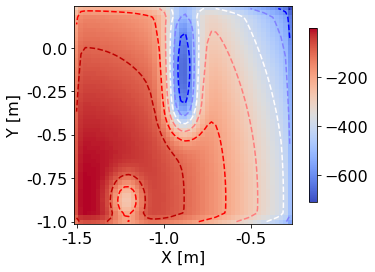

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


# Transpose the data array to rotate the heatmap
data_rotated = cost_matrix.reshape(50,50)

# Create a figure and axes
fig, ax = plt.subplots()

# # Custom normalization range
vmin = 0  # minimum value
vmax = 500  # maximum value

# Creating a custom normalization
norm = Normalize(vmin=vmin, vmax=vmax)

# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.8)

# Add labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_title('Rotated Heatmap')

ax.invert_yaxis()

# # # Generate positions matching the data grid
# x_positions = np.linspace(0, data_rotated.shape[1] - 1, 7)  # Match with labels
# y_positions = np.linspace(0, data_rotated.shape[0] - 1, 8)  # Match with labels

# # Define the labels
x_labels = np.linspace(-1.5, 1.5, 7)
y_labels = np.linspace(-1.0, 1.0, 8)

# # Set the x and y ticks and corresponding labels
# ax.set_xticks(x_positions)
# ax.set_xticklabels([f"{x:.1f}" for x in x_labels], fontsize=12)

# ax.set_yticks(y_positions)
# ax.set_yticklabels([f"{y:.1f}" for y in y_labels], fontsize=12)

# Define the desired tick positions and labels for x and y axes
x_ticklabels = np.arange(-2, 2, 0.5)  # Example: custom tick labels for x-axis
y_ticklabels = np.arange(-1.25, 1.25, 0.25)  # Example: custom tick labels for y-axis

# Set the x and y axis tick positions and labels
ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)


# Display the plot
plt.show()
# plt.savefig('Cost_Heat_Map_ROBO.jpg',dpi=500,bbox_inches ='tight')

In [176]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration_Soft(env,cost_matrix,discount_factor=0.9)

# we run the iterations
value_iteration.iterate(2000)

CONVERGED after iteration 56


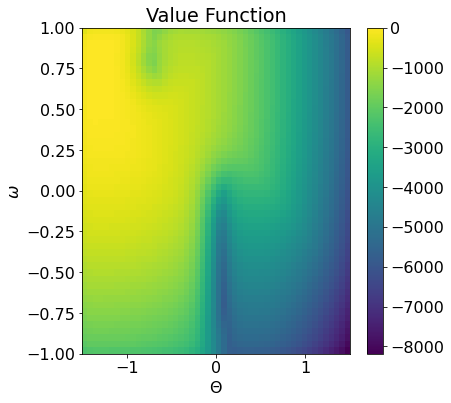

In [177]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[6,6])
im = plt.imshow(value_iteration.value_function.reshape((env.nx, env.ny)),  extent=[-1.5, 1.5, -1.0, 1.0],aspect='auto')
plt.colorbar(im,orientation="vertical")
plt.xlabel('$\Theta$')
plt.ylabel('$\omega$')
plt.title('Value Function')
plt
# plt.savefig('expert_value_function.jpg',dpi=1000,bbox_inches ='tight')

plt.show()

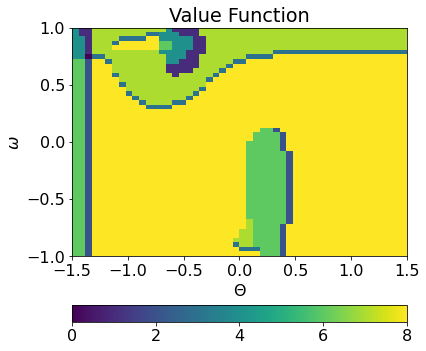

In [178]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[6,6])
im = plt.imshow(value_iteration.policy.argmax(axis=1).reshape((env.nx, env.ny)),  extent=[-1.5, 1.5, -1.0, 1.0],aspect='auto')
plt.colorbar(im,orientation="horizontal")
plt.xlabel('$\Theta$')
plt.ylabel('$\omega$')
plt.title('Value Function')

# plt.savefig('expert_value_function.jpg',dpi=1000,bbox_inches ='tight')

plt.show()

In [179]:
initial_state = np.array([[1.4, 0.9],[0.2,0.9],[1.2,-0.8],[-1.4,0.9]])  # Starting at the origin
random_policy = np.ones([env.num_states, env.nu]) / env.nu  # Uniform random policy
trajectory, actions = env.simulate(initial_state[1], value_iteration.policy, T=1000)

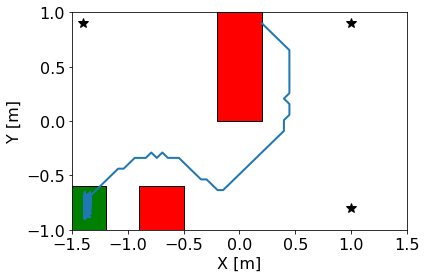

In [180]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

plt.plot(trajectory[0,:],trajectory[1,:],linewidth=2)

plt.plot(1.,0.9,'*',color='black',markersize=10)
# plt.plot(0.2,0.9,'*',color='black',markersize=10)
plt.plot(1.0,-0.8,'*',color='black',markersize=10)
plt.plot(-1.4,0.9,'*',color='black',markersize=10)

#plt.axes()
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")

square3 = plt.Rectangle((-0.9,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 1, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.show()

In [181]:
XX = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\State_Data_Simulation_DR_inv.npy',allow_pickle=True)
# XX_Prev = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\State_Data_Simulation_Prev_1.npy',allow_pickle=True)
UU = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\Input_Data_Simulation_DR_inv.npy',allow_pickle=True)

In [182]:
X = []
X_plot = []

X_Prev = []
X_plot_Prev = []

U = []
U_plot = []

for i in range(1):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(1):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

In [183]:
trajectory = [env.generate_trajectories(initial_state[i], value_iteration.policy, 1000) for i in range(4)]

In [184]:
# Define the number of features
num_features = 2  # For the given feature vector

def feature_expectation(trajectory,num_features,obs_points,goal_points): 

    # Initialize the sum of feature counts
    sum_feature_counts = np.zeros(num_features)
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    # Calculate feature expectation
    for t in trajectory:
        for iter, state in enumerate(t.states()):
            # Calculate the feature vector for the current state
            s = env.get_state(state)
            gauss_sum = 0
            for i in range(np.size(obs_points,axis=1)):
                gauss_sum += logpdf(s[:2],obs_points[:2,i],covar)
            features = np.array([
                float((s[0]-goal_points[0])**2 + (s[1]-goal_points[1])**2),
                gauss_sum 
                # (np.exp(-0.5*((s[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                #     + np.exp(-0.5*((s[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((s[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                #     + np.exp(-0.5*((s[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
            ])
            sum_feature_counts += (0.9**(iter))*features

    # # Compute empirical feature expectation
    num_trajectories = len(trajectory)
    e_features = sum_feature_counts / num_trajectories
    
    return(e_features)

e_features = feature_expectation(trajectory,num_features,obs_points,goal_points)

print(e_features)

[47.1562381   2.12493267]


In [ ]:
# Define the number of features
num_features = 2  # For the given feature vector

def feature_expectation(trajectory,num_features,obs_points,goal_points): 

    # Initialize the sum of feature counts
    sum_feature_counts = np.zeros(num_features)
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    # Calculate feature expectation
    for t in trajectory:
        for iter, state in enumerate(t.states()):
            # Calculate the feature vector for the current state
            s = env.get_state(state)
            gauss_sum[] = 0
            for i in range(np.size(obs_points,axis=1)):
                gauss_sum += logpdf(state[:2],obs_points[:2,i],covar)
            features = np.array([
                float((s[0]-goal_points[0])**2 + (s[1]-goal_points[1])**2),
                gauss_sum
                # (np.exp(-0.5*((s[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                #     + np.exp(-0.5*((s[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((s[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                #     + np.exp(-0.5*((s[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
            ])
            sum_feature_counts += (0.99**(iter))*features

    # # Compute empirical feature expectation
    num_trajectories = len(trajectory)
    e_features = sum_feature_counts / num_trajectories
    
    return(e_features)

# e_features = feature_expectation(trajectory,num_features,obs_points,goal_points)

# print(e_features)

In [ ]:
def L_state_cost(ind,env,goal_points,obs_points,theta):
    """
    Calculate state cost considering goal and obstacles
    Args:
        state (array): Current state
        goal_points (array): Goal points
        obs_points (array): Obstacle points
    Returns:
        float: State cost
    """
    state = env.get_state(ind)
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += theta[i+1]*logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = theta[0]*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum -5*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                    + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                    + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    return(cost)

In [ ]:
init = O.Uniform(low=-1.0,high=0.0)
# init = O.Constant(0.0)
optim = O.ExpSga(lr=O.linear_decay(lr0=10.0))
# omega = np.random.uniform(size=(2,), low=-1.0, high=1.0)
omega = init(2) 
optim.reset(omega)              # re-start optimizer
eps=1e-2
delta = np.inf

print('omega init:',omega)

while delta > eps:              # iterate until convergence
    omega_old = omega.copy()

    # compute per-state reward from features
    IHMCE_reward = cost_mat(L_state_cost,env,goal_points,obs_points,omega)
    # reward = features.dot(omega)

    # compute gradient of the log-likelihood
    VI = ValueIteration_Soft(env,IHMCE_reward,discount_factor=0.9)
    VI.iterate(num_iter=2000)
    
    initial_state = np.array([[1.4, 0.9],[0.2,0.9],[1.2,-0.8],[-1.4,0.9]]) 
    # Compute state visitation frequencies
    trajectory = [env.generate_trajectories(initial_state[i], value_iteration.policy, 1000) for i in range(4)]
    
    e_svf = feature_expectation(trajectory,num_features,obs_points_f,goal_points)
    
    # re-compute detla for convergence check
    delta = np.max(np.abs(e_features-e_svf)/np.abs(e_svf))
    print('delta:',delta)

    grad = e_features - e_svf
    
    # omega += 0.9 * grad
    # omega *= np.exp(0.9 * grad) # exponential gradient
    # omega/=omega.sum() # normalising weigths
    # perform optimization step and compute delta for convergence
    optim.step(grad)
    
    print('omega:',omega)

In [140]:
cost_matrix = cost_mat(L_state_cost,env,goal_points,obs_points_f,-omega)

np.save('Cost_Matrix_IHMCE.npy',cost_matrix)

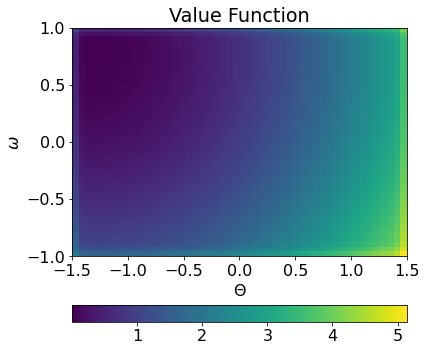

In [141]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=[6,6])
im = plt.imshow(cost_matrix.reshape((env.nx,env.ny)),  extent=[-1.5, 1.5, -1.0, 1.0],aspect='auto')
plt.colorbar(im,orientation="horizontal")
plt.xlabel('$\Theta$')
plt.ylabel('$\omega$')
plt.title('Value Function')

# plt.savefig('expert_value_function.jpg',dpi=1000,bbox_inches ='tight')

plt.show()

In [36]:
initial_state = np.array([[1.4, 0.9],[0.2,0.9],[1.2,-0.8],[-1.4,0.9]])  # Starting at the origin
random_policy = np.ones([env.num_states, env.nu]) / env.nu  # Uniform random policy
trajectory, actions = env.simulate(initial_state[0], VI.policy, T=1000)

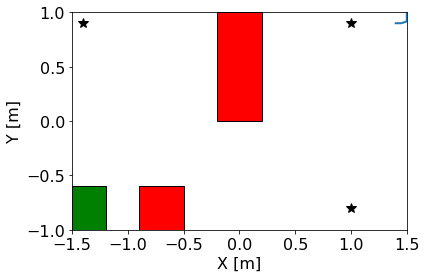

In [37]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

plt.plot(trajectory[0,:],trajectory[1,:],linewidth=2)

plt.plot(1.,0.9,'*',color='black',markersize=10)
# plt.plot(0.2,0.9,'*',color='black',markersize=10)
plt.plot(1.0,-0.8,'*',color='black',markersize=10)
plt.plot(-1.4,0.9,'*',color='black',markersize=10)

#plt.axes()
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")

square3 = plt.Rectangle((-0.9,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 1, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.show()